In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser

from tqdm import tqdm
from datetime import timedelta
from sklearn.decomposition import NMF


In [113]:
tqdm.pandas()

In [4]:
billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year

billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958


In [5]:
plt.rcParams.update({'font.size': 15})

In [6]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(
    ["artist", "song_name"])["position"].transform("min")

In [7]:
rows_to_add = []

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]
    
    songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10) & ~((billboard_hot_100["artist"].isin(songs_from_other_decades["artist"]) &\
            billboard_hot_100["song_name"].isin(songs_from_other_decades["song_name"])))][["artist", "song_name", "weeks_on_chart",
                "position", "first_day_of_the_week", "year", "top_position"]]
    grouped = songs_in_decade.groupby(["artist", "song_name"])

    min_first_week = songs_in_decade["first_day_of_the_week"].min().to_pydatetime()

    for name, group in grouped:
        max_week = group["first_day_of_the_week"].max().to_pydatetime()

        for row_index, row in group.iterrows():
            if row["first_day_of_the_week"] == max_week:
                week_date = row["first_day_of_the_week"] + timedelta(weeks=1)

                while week_date < dateutil.parser.parse(f"{year + 9}-12-31"):
                    rows_to_add.append({
                        "artist": row["artist"],
                        "song_name": row["song_name"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "first_day_of_the_week": week_date,
                        "year": week_date.year,
                        "top_position": row["top_position"]
                    })
                    week_date += timedelta(weeks=1)

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100[["artist", "song_name",
    "weeks_on_chart", "position", "first_day_of_the_week", "year", "top_position"]], pd.DataFrame(rows_to_add)], ignore_index=True)

In [30]:
# concatenate artist and song name
billboard_hot_100["artist_song"] = billboard_hot_100["artist"] + " - " +\
    billboard_hot_100["song_name"]

In [97]:
pv_table = billboard_hot_100.pivot_table(index="first_day_of_the_week",
        columns="artist_song", values="position", fill_value=101)

In [140]:
nmf = NMF(n_components=6, init='random', random_state=0)
nmf.fit(pv_table)

NMF(init='random', n_components=6, random_state=0)

In [141]:
nmf_features = nmf.transform(pv_table)

In [142]:
def display_components(model, song_names, num_top_positions):
    # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for ix, archetype in enumerate(model.components_):
        #print topic, topic number, and top words
        print("\nArchetype ", ix)
        print(", ".join([song_names[i] \
             for i in archetype.argsort()[:-num_top_positions - 1:-1]]))

In [143]:
display_components(nmf, billboard_hot_100["artist_song"].values, 5)


Archetype  0
Duane Eddy and the Rebelettes - Boss Guitar, Sam Cooke - Somebody Have Mercy, Joe Perkins - Little Eeefin Annie, Dionne Warwick - Anyone Who Had A Heart, The Goodtimers - Pony Time

Archetype  1
The Crests - Trouble In Paradise, Chubby Checker - Let's Limbo Some More, Etta James - Loving You More Every Day, Johnny Crawford - Judy Loves Me, Lee Dorsey - Ya Ya

Archetype  2
The Shells - Baby Oh Baby, Peter, Paul & Mary - Tell It On The Mountain, The Jive Five With Joe Rene And Orchestra - My True Story, Bobby Rydell - Ding-A-Ling, Jim Reeves - Guilty

Archetype  3
The Four Preps - Lazy Summer Night, The Secrets - The Boy Next Door, Johnny Burnette - You're Sixteen, Tommy Mara - Where The Blue Of The Night, Rolf Harris - Sun Arise

Archetype  4
Ronnie Hawkins and The Hawks - Mary Lou, Paul Anka - Love Me Warm And Tender, Dee Clark - You're Looking Good, Neil Sedaka - Alice In Wonderland, Duane Eddy - The Ballad Of Paladin

Archetype  5
The Platters Featuring Tony Williams - 

In [144]:
billboard_100_with_empty_weeks["first_week"] = billboard_100_with_empty_weeks.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")

In [145]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(nmf.components_, columns=billboard_hot_100["artist_song"].drop_duplicates().values)
components_df

,Domenico Modugno - Nel Blu Dipinto Di Blu (Volare),The Elegants - Little Star,The Everly Brothers - Bird Dog,Jimmy Clanton And His Rockets - Just A Dream,Perez Prado And His Orchestra - Patricia,Ricky Nelson - Poor Little Fool,Jack Scott - My True Love,Bobby Day - Rock-in Robin,Frankie Avalon - Ginger Bread,The Olympics - Western Movies,...,Juice WRLD - Face 2 Face,Pentatonix Featuring Meghan Trainor - Kid On Christmas,SZA - Conceited,SZA - Far,Nengo Flow & Bad Bunny - Gato de Noche,Carin Leon X Grupo Frontera - Que Vuelvas,Fuerza Regida X Grupo Frontera - Bebe Dame,SZA - Too Late,SZA Featuring Ol' Dirty Bastard - Forgiveless,A Boogie Wit da Hoodie Featuring Kodak Black - Water (Drowning Pt. 2)
0,2.311447,5.629861,2.876751,3.008506,6.690657,0.000000,4.783876,3.544723,5.707874,0.551134,...,2.053872,3.736014,3.497382,3.294742,5.002468,5.595239,0.016129,1.979725,4.195820,4.110163
1,3.360078,1.087890,1.346824,5.346283,0.987466,8.542672,2.589424,4.554402,1.382413,8.631353,...,4.594489,2.202310,2.380770,1.907891,1.350039,2.233493,7.915812,6.138659,2.415332,1.980736
2,3.810850,2.741884,7.371312,2.442238,3.221548,2.823523,2.311782,3.801718,1.926876,3.418247,...,4.663129,2.928177,2.663818,5.910692,5.112855,2.474382,0.719668,0.696497,2.605287,4.991246
3,5.382578,4.084484,0.843070,1.049212,3.551452,5.443130,2.798823,3.223356,3.979961,3.471395,...,3.154300,4.624450,7.168787,0.900498,2.790307,4.374436,5.719886,2.333125,4.170364,3.731321
4,3.927050,3.856807,6.077712,3.943889,2.039950,3.190632,4.887165,3.626335,1.088587,2.485208,...,3.781643,3.408735,3.027813,3.225293,1.915662,3.262131,4.230519,3.038637,3.755111,1.945695
5,3.583723,2.228417,3.737237,5.442197,1.956227,3.331055,2.708411,1.984815,5.435397,4.148469,...,3.752648,4.410932,2.563031,6.484767,3.896007,1.367616,4.992200,7.993745,3.632949,4.092225


In [146]:
billboard_100_with_empty_weeks["archetype"] = billboard_100_with_empty_weeks.progress_apply(lambda row: components_df.loc[:, row["artist_song"]].argmax(), axis=1)


100%|██████████| 6343727/6343727 [22:57<00:00, 4605.11it/s] 


In [147]:
nmf_features_pd = pd.DataFrame(nmf_features)

nmf_features_pd

,0,1,2,3,4,5
0,7.980293,5.041754,4.098834,3.942222,3.839577,3.799511
1,7.978389,5.038438,4.101868,3.948739,3.841964,3.792631
2,7.976178,5.033087,4.102680,3.944461,3.844567,3.799838
3,7.976841,5.037291,4.101333,3.948527,3.842342,3.795311
4,7.977341,5.037905,4.098985,3.951573,3.840030,3.795877
...,...,...,...,...,...,...
3356,7.982042,5.042952,4.110264,3.927186,3.828287,3.812202
3357,7.976717,5.036054,4.104379,3.931511,3.829718,3.822485
3358,7.972255,5.037866,4.103720,3.934374,3.834300,3.818288
3359,7.975113,5.039727,4.111794,3.923787,3.832300,3.818929


6it [06:48, 68.10s/it]


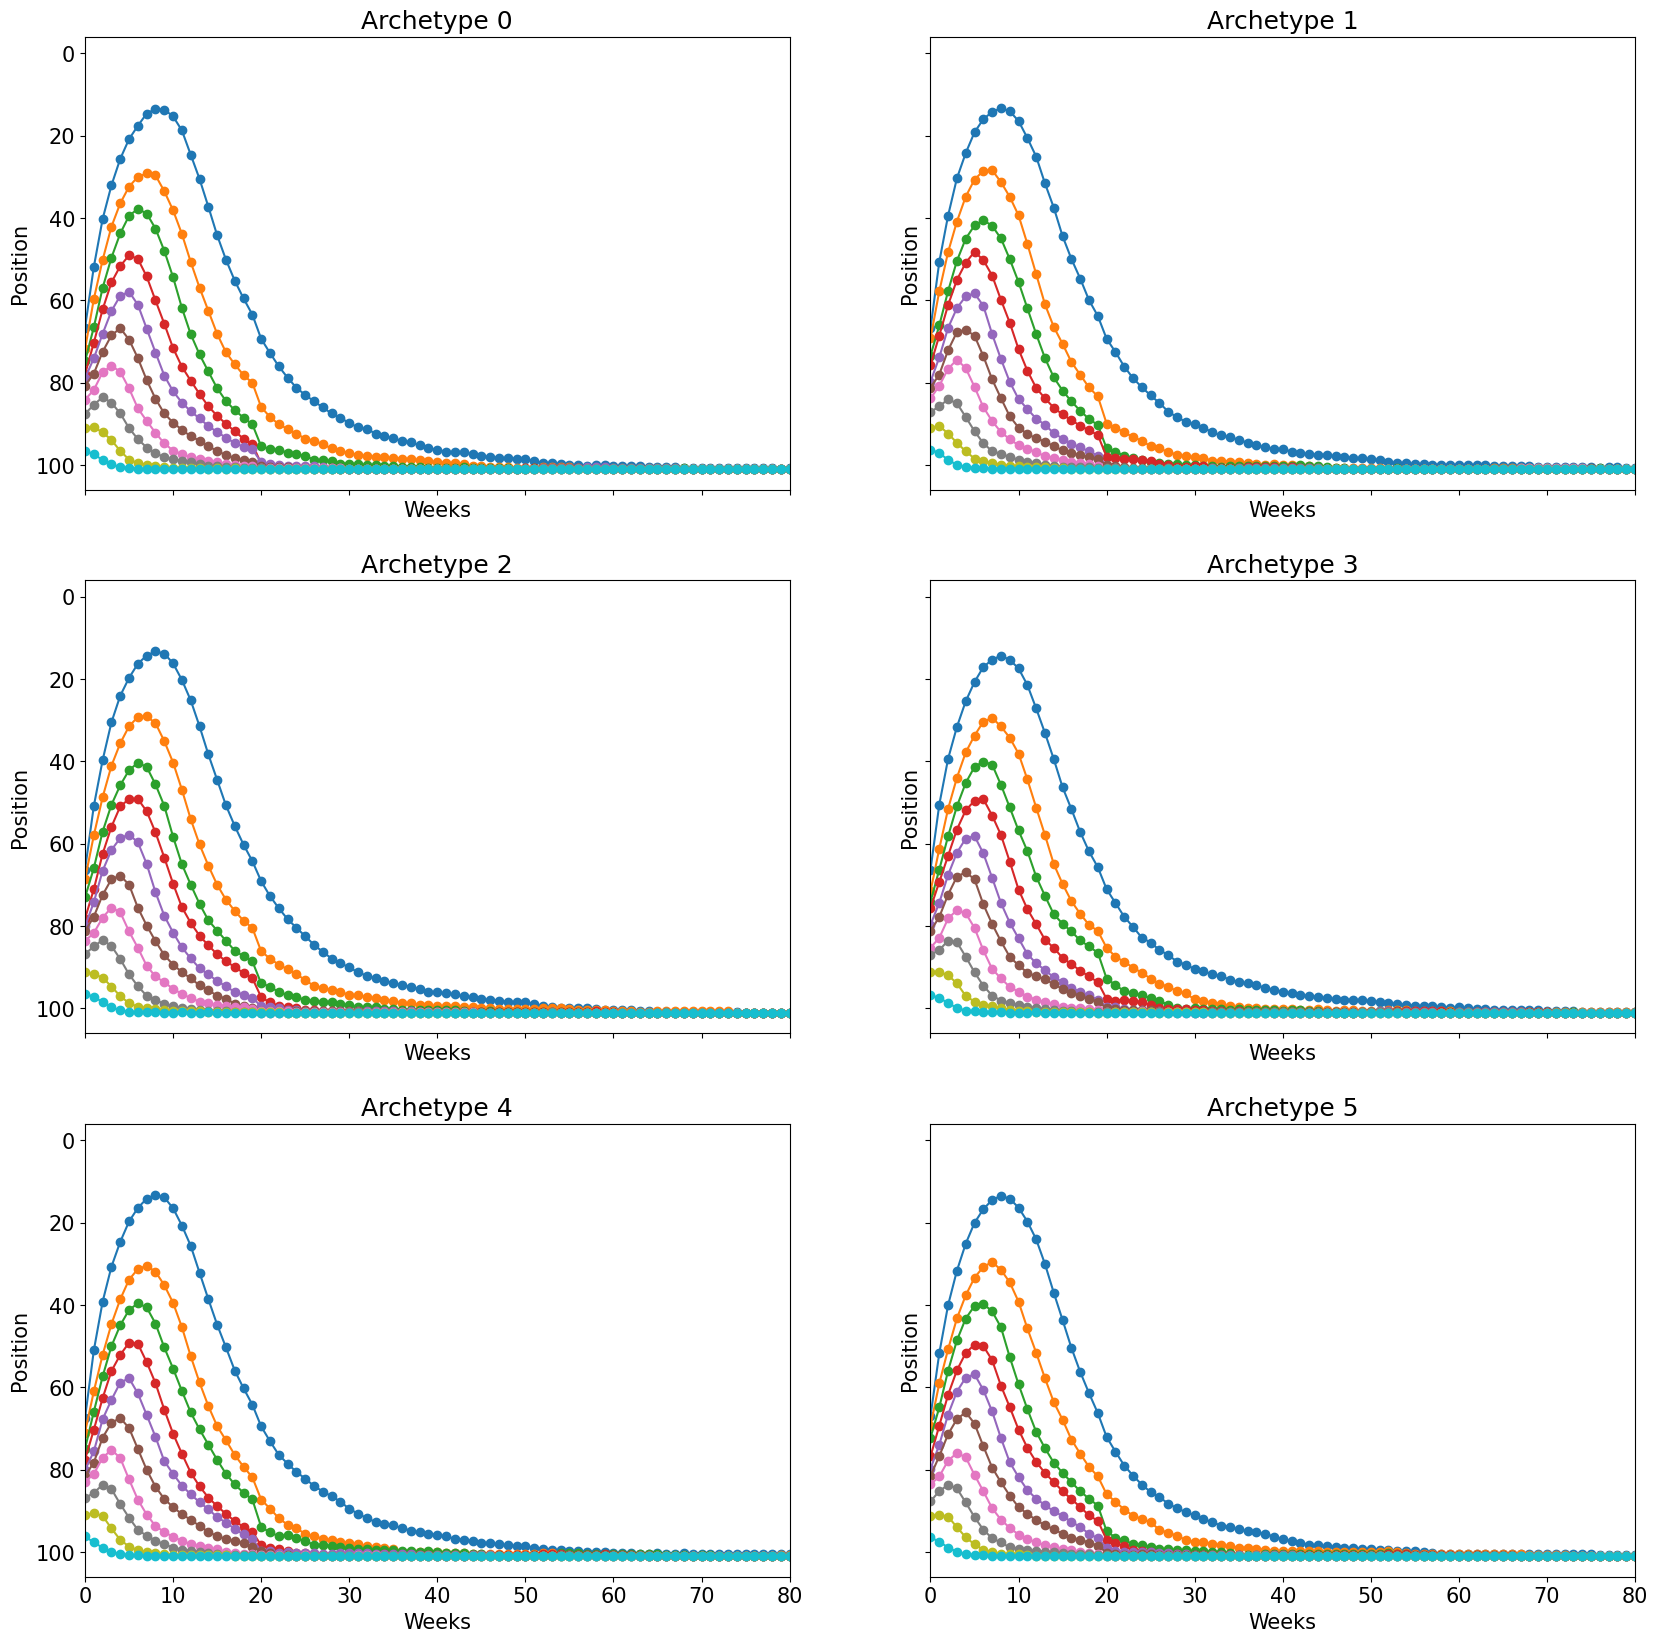

In [148]:
# plot all trajectories of archetype 0
fig, axes = plt.subplots(int(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for top_position in range(10, 110, 10):
        songs_from_archetype = billboard_100_with_empty_weeks[billboard_100_with_empty_weeks["archetype"] == ix]
        songs_from_archetype = songs_from_archetype[(songs_from_archetype["top_position"] <= top_position) &\
            (songs_from_archetype["top_position"] > top_position - 10)][["artist_song"]]
        songs_from_archetype = songs_from_archetype[["artist_song"]].drop_duplicates().merge(
            billboard_100_with_empty_weeks[["artist_song",
                "position", "first_day_of_the_week", "first_week"]], on=["artist_song"], how="left")
        min_first_week = songs_from_archetype["first_day_of_the_week"].min().to_pydatetime()
        songs_from_archetype["first_day_of_the_week"] = songs_from_archetype.apply(lambda row:
            int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)
        axes[row_i, col_i].plot(songs_from_archetype.groupby("first_day_of_the_week")["position"].mean(),
            marker='o')
        
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.xlim(0, 80)
plt.gca().invert_yaxis()
plt.show()

100%|██████████| 2000/2000 [00:02<00:00, 709.78it/s]
6it [00:24,  4.08s/it]


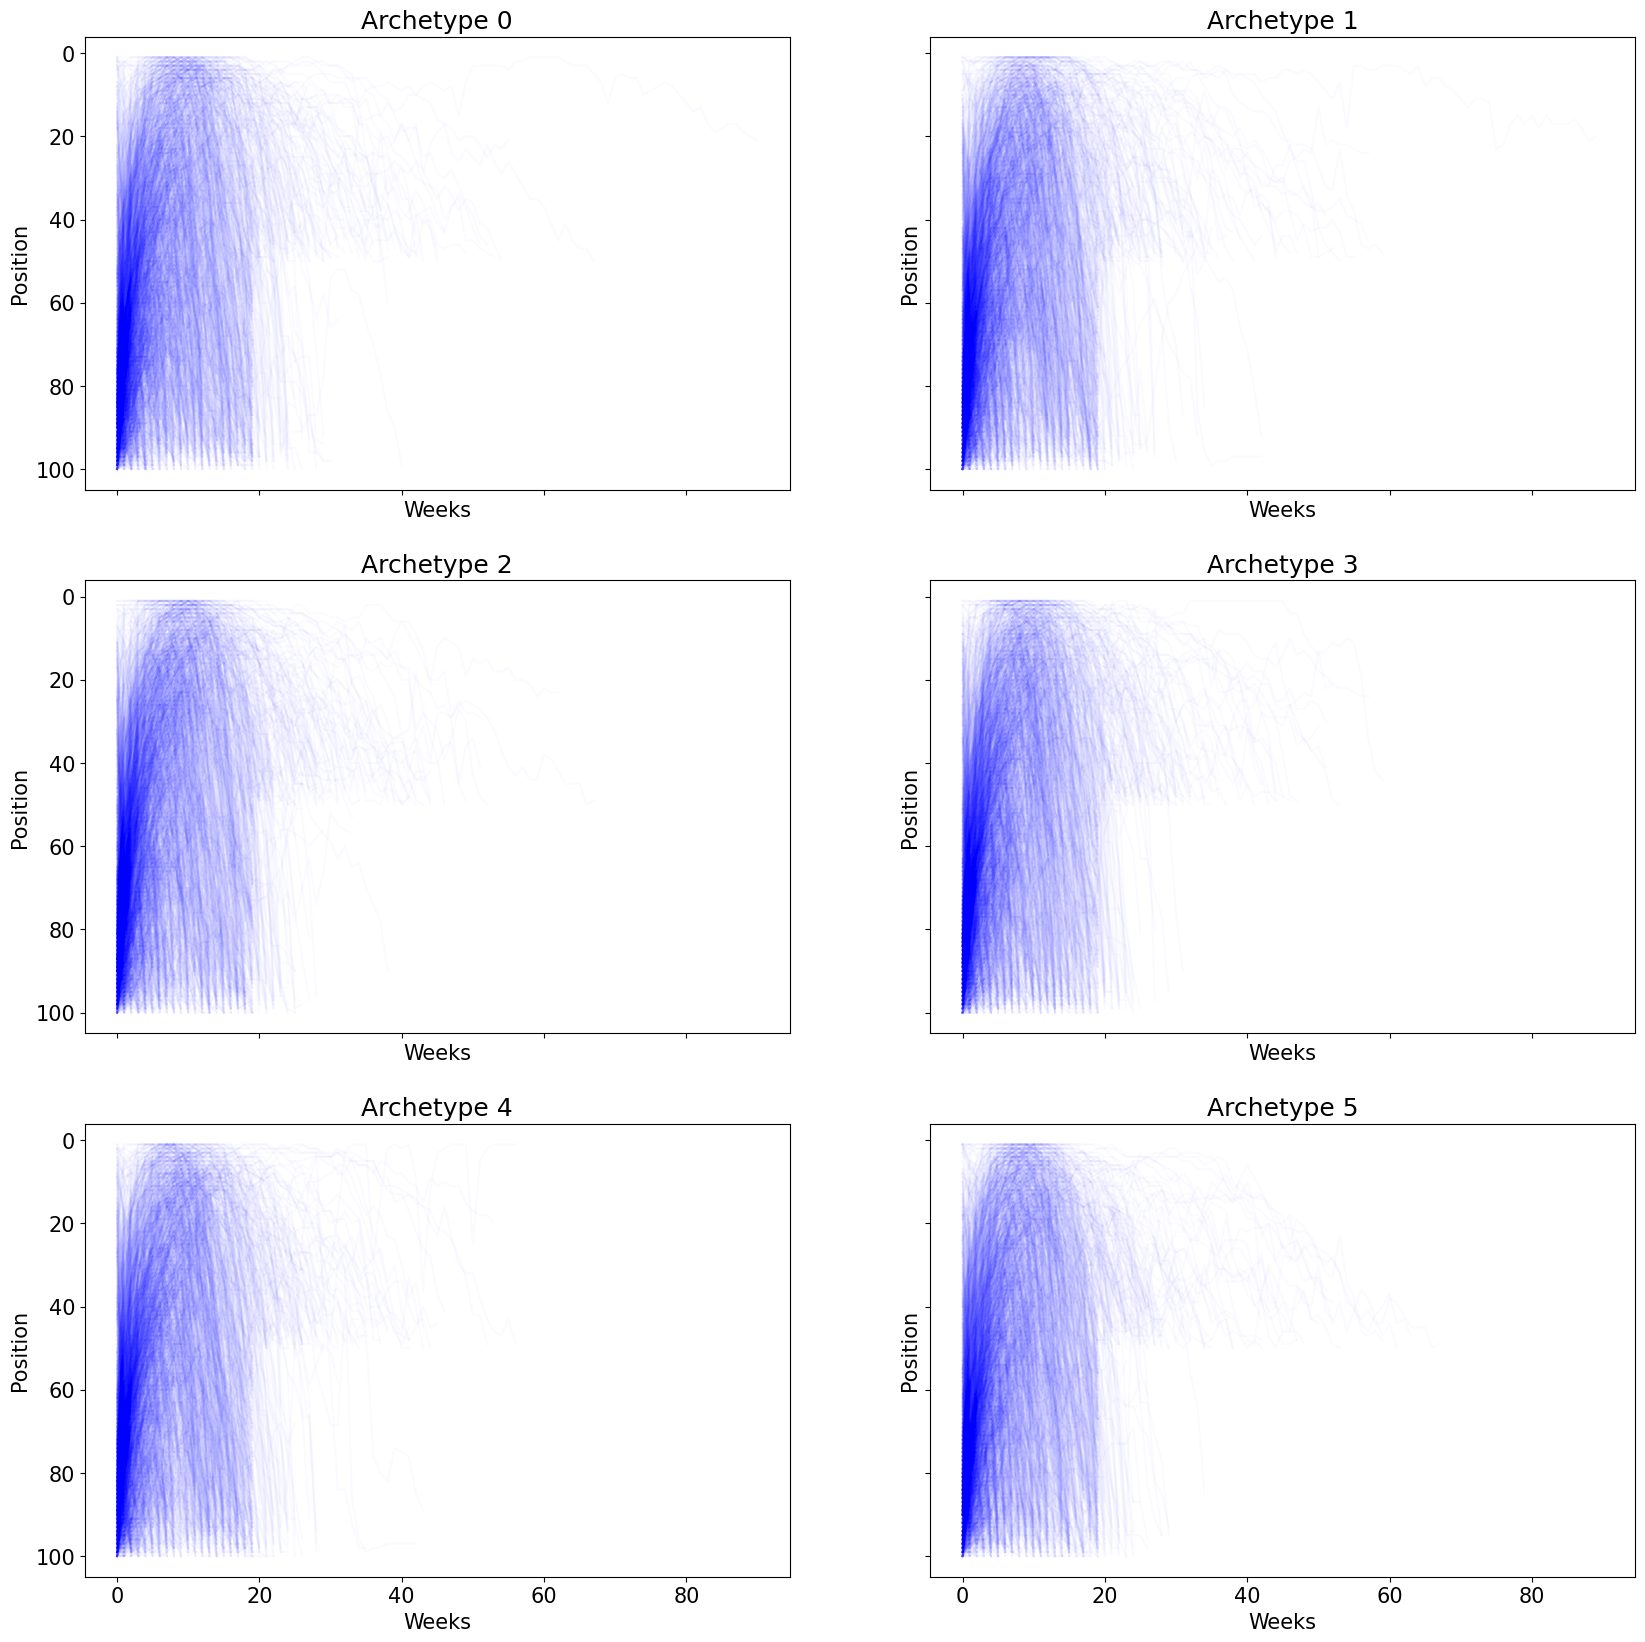

In [149]:
fig, axes = plt.subplots(int(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

# artist_songs = pv_table.columns[archetype.argsort()]
# songs_from_archetype = billboard_100_with_empty_weeks[billboard_100_with_empty_weeks["artist_song"].isin(artist_songs)]
# min_first_week = songs_from_archetype["first_day_of_the_week"].min().to_pydatetime()
# songs_from_archetype["first_day_of_the_week"] = songs_from_archetype.apply(lambda row:
#     int(((min_first_week + timedelta(
#             days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)
for ix, archetype in tqdm(enumerate(nmf.components_)):
    for i in tqdm(archetype.argsort()[:-2000 - 1:-1]):
        trajectory = pv_table.iloc[:, i].values
        trajectory = trajectory[trajectory != 101]
        axes[row_i, col_i].plot(trajectory, alpha=0.02, color="blue")
    
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")


    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.gca().invert_yaxis()
plt.show()